In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
# === CONFIG ===
IMG_SIZE = 224
BATCH_SIZE = 32
DATA_DIR = "C:\Skin Classification\HAM10000_images"
CSV_PATH = "C:\Skin Classification\HAM10000_images\HAM10000_metadata.csv"

In [3]:
# === LOAD DATA ===
df = pd.read_csv(CSV_PATH)
df['image_id'] = df['image_id'] + ".jpg"
df['path'] = df['image_id'].apply(lambda x: os.path.join(DATA_DIR, x))

le = LabelEncoder()
df['label'] = le.fit_transform(df['dx'])
num_classes = len(le.classes_)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [4]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,label
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp,C:\Skin Classification\HAM10000_images\ISIC_00...,2
1,HAM_0000118,ISIC_0025030.jpg,bkl,histo,80.0,male,scalp,C:\Skin Classification\HAM10000_images\ISIC_00...,2
2,HAM_0002730,ISIC_0026769.jpg,bkl,histo,80.0,male,scalp,C:\Skin Classification\HAM10000_images\ISIC_00...,2
3,HAM_0002730,ISIC_0025661.jpg,bkl,histo,80.0,male,scalp,C:\Skin Classification\HAM10000_images\ISIC_00...,2
4,HAM_0001466,ISIC_0031633.jpg,bkl,histo,75.0,male,ear,C:\Skin Classification\HAM10000_images\ISIC_00...,2
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084.jpg,akiec,histo,40.0,male,abdomen,C:\Skin Classification\HAM10000_images\ISIC_00...,0
10011,HAM_0002867,ISIC_0033550.jpg,akiec,histo,40.0,male,abdomen,C:\Skin Classification\HAM10000_images\ISIC_00...,0
10012,HAM_0002867,ISIC_0033536.jpg,akiec,histo,40.0,male,abdomen,C:\Skin Classification\HAM10000_images\ISIC_00...,0
10013,HAM_0000239,ISIC_0032854.jpg,akiec,histo,80.0,male,face,C:\Skin Classification\HAM10000_images\ISIC_00...,0


In [5]:
print(df['dx'].unique())

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


In [6]:
# === IMAGE DATA GENERATOR ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='raw',
    batch_size=BATCH_SIZE
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='raw',
    batch_size=BATCH_SIZE
)

Found 8012 validated image filenames.
Found 2003 validated image filenames.


In [7]:
# === MODEL ===
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [8]:
# === CLASS WEIGHTS ===
y_train_labels = train_df['label'].values
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))

In [9]:
# === COMPILE ===
model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
# === TRAIN ===
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weights_dict
)

# === EVALUATE ===
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 1510s 6s/step - accuracy: 0.2426 - loss: 2.2584 - val_accuracy: 0.0140 - val_loss: 3.5951
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 1574s 6s/step - accuracy: 0.4415 - loss: 1.5202 - val_accuracy: 0.0175 - val_loss: 2.5879
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 1554s 6s/step - accuracy: 0.5308 - loss: 1.3002 - val_accuracy: 0.1243 - val_loss: 1.9587
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 1600s 6s/step - accuracy: 0.5926 - loss: 1.0627 - val_accuracy: 0.5861 - val_loss: 1.2924
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 1565s 6s/step - accuracy: 0.6331 - loss: 0.8994 - val_accuracy: 0.7000 - val_loss: 0.8503
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 1566s 6s/step - accuracy: 0.6477 - loss: 0.8145 - val_accuracy: 0.7049 - val_loss: 0.7987
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 1616s 6s/step - accuracy: 0.6780 - loss: 0.7490 - val_accuracy: 0.7214 - val_loss: 0.7549
Epoch 8/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 1590s 6s/step - accuracy: 0.6779 - loss: 0.7437 - 

In [23]:
# === Print Final Training and Validation Accuracy ===
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")


Final Training Accuracy: 85.37%
Final Validation Accuracy: 77.23%


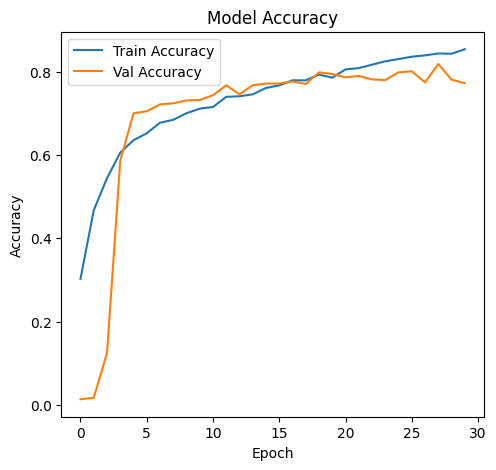

In [14]:
import matplotlib.pyplot as plt
# === PLOT TRAINING HISTORY ===
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

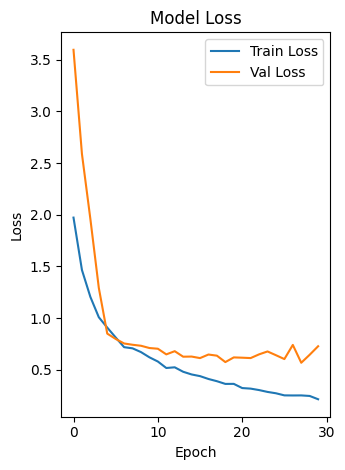

In [30]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
from sklearn.metrics import classification_report
# === CLASSIFICATION REPORT ===
y_true = val_df['label'].values
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))

63/63 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step

Classification Report:

              precision    recall  f1-score   support

       akiec       0.11      0.05      0.06        65
         bcc       0.02      0.02      0.02       103
         bkl       0.12      0.22      0.16       220
          df       0.04      0.04      0.04        23
         mel       0.13      0.22      0.16       223
          nv       0.68      0.54      0.60      1341
        vasc       0.00      0.00      0.00        28

    accuracy                           0.41      2003
   macro avg       0.16      0.15      0.15      2003
weighted avg       0.49      0.41      0.44      2003



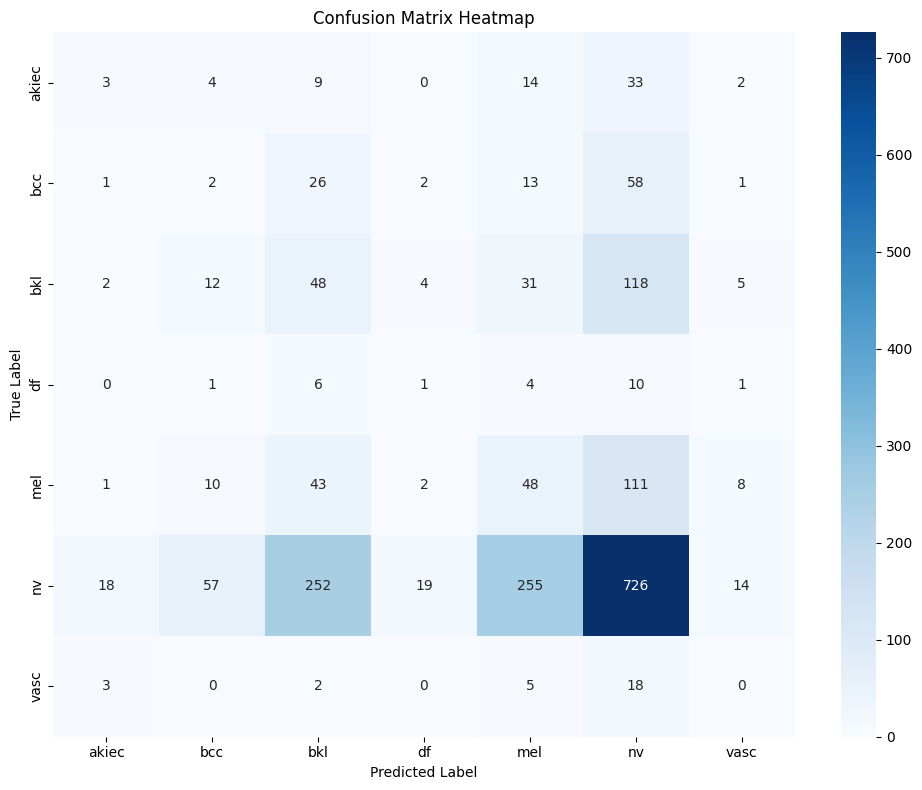

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# === CONFUSION MATRIX HEATMAP ===
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [20]:
MODEL_PATH = "skinlesionmodel.h5"
model.save(MODEL_PATH)


In [22]:
from tensorflow.keras.models import load_model
model = load_model("skinlesionmodel.h5")

In [29]:
from tensorflow.keras.preprocessing import image

# Load and preprocess new image
img_path = "C:/Users/Subhasri/OneDrive/Pictures/Screenshots/Screenshot 2025-07-27 041628.png"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict
pred = model.predict(img_array)
predicted_class = np.argmax(pred)
class_name = le.classes_[predicted_class]

print(f"Predicted class: {class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Predicted class: bkl


In [25]:
val_df, test_df = train_test_split(val_df, test_size=0.5, stratify=val_df['label'], random_state=42)
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=False
)



Found 501 validated image filenames.


In [26]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")


c:\Skin Classification\Skin-lesion\tf-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 961ms/step - accuracy: 0.7569 - loss: 0.8184

Test Accuracy: 76.65%


In [2]:
print("hello")

hello


In [3]:
print("Subha")

Subha
